In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import load_and_process_data

# Configuration for aesthetics
plt.style.use('bmh')
%matplotlib inline

/home/nazrawi/brent-oil-changepoint/venv/lib/python3.14/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Loading data from ../data/BrentOilPrices.csv...
Parsing dates (this may take a moment)...
Data filtered from 9011 to 3260 rows (Post-2010-01-01).


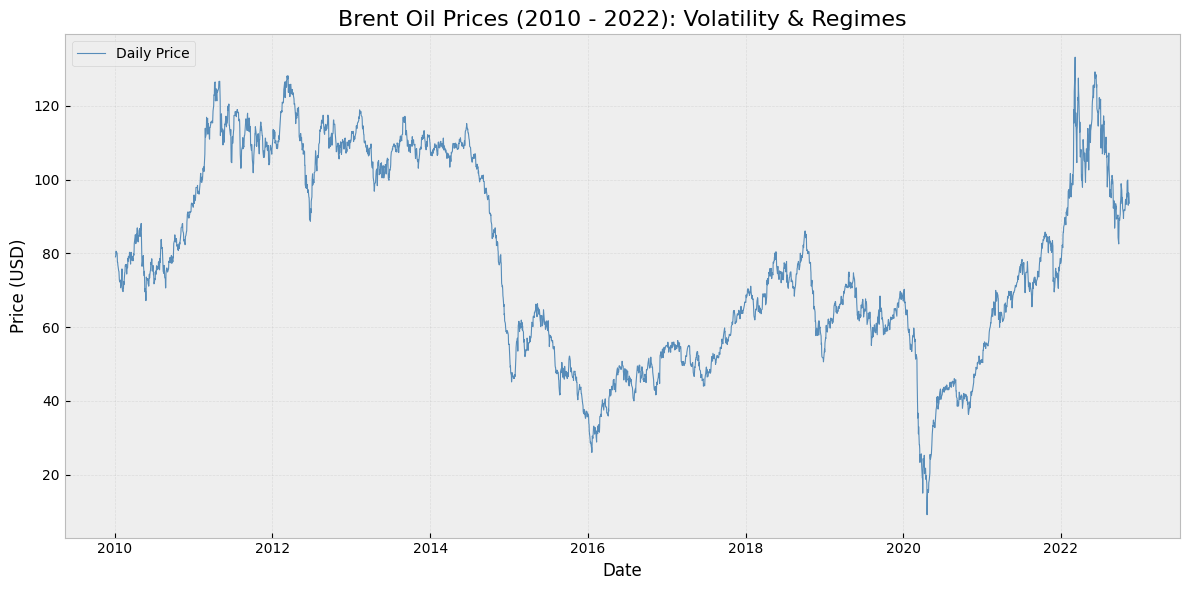

In [2]:
# Load data using our robust loader
# We use the relative path since notebooks are inside the 'notebooks/' folder
df = load_and_process_data('../data/BrentOilPrices.csv', start_date='2010-01-01')

# Visualize the raw time series to understand the volatility
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='steelblue', linewidth=0.8, alpha=0.9, label='Daily Price')

# Add context (Business Objective: Understanding Market Regimes)
plt.title('Brent Oil Prices (2010 - 2022): Volatility & Regimes', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

# --- EXTENDED EDA: Stationarity & Volatility ---

# 1. Augmented Dickey-Fuller Test (Stationarity)
print("--- 1. Stationarity Test (ADF) ---")
adf_result = adfuller(df['Price'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] > 0.05:
    print("Interpretation: p-value > 0.05. Fail to reject Null Hypothesis.")
    print("Conclusion: The time series is NON-STATIONARY (Mean/Variance change over time).")
    print("This confirms that Change Point Detection is an appropriate approach.")
else:
    print("Conclusion: The time series is STATIONARY.")

# 2. Volatility Analysis (Log Returns)
print("\n--- 2. Volatility Analysis ---")
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
df['Volatility_30d'] = df['Log_Return'].rolling(window=30).std()

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Log_Return'], color='grey', alpha=0.5, lw=0.5, label='Daily Log Returns')
plt.plot(df['Date'], df['Volatility_30d'], color='red', lw=1.5, label='30-Day Rolling Volatility')
plt.title("Brent Oil Volatility Analysis (Log Returns)", fontsize=14)
plt.legend()
plt.show()

print("Observation: Note the 'Volatility Clustering' around 2014, 2020, and 2022.")

ModuleNotFoundError: No module named 'statsmodels'

In [3]:
# Prepare data for PyMC
prices = df['Price'].values
n_samples = len(prices)
idx = np.arange(n_samples)

print(f"Running MCMC on {n_samples} data points...")

with pm.Model() as model_brent:
    # --- PRIORS ---
    # We use domain knowledge for priors, not random guesses.
    # Mu (Mean): Oil prices generally stay between $20 and $120.
    # Sigma (Volatility): Oil is volatile, so we allow a flexible standard deviation.
    
    mu_1 = pm.Normal('mu_1', mu=80, sigma=20)  # Regime 1 Mean
    mu_2 = pm.Normal('mu_2', mu=60, sigma=20)  # Regime 2 Mean
    
    sigma = pm.HalfNormal('sigma', sigma=10)   # Noise
    
    # Tau (Change Point): any day is equally likely a priori
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_samples - 1)
    
    # --- LIKELIHOOD ---
    # If day_index < tau, price comes from regime 1, else regime 2
    mu = pm.math.switch(tau >= idx, mu_1, mu_2)
    
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=prices)

Running MCMC on 3260 data points...


In [4]:
# Run the sampler
# We use 2 chains to check for convergence (they should look identical)
with model_brent:
    trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9, random_seed=42)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_1, mu_2, sigma]
>Metropolis: [tau]


Output()

/home/nazrawi/brent-oil-changepoint/venv/lib/python3.14/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/home/nazrawi/brent-oil-changepoint/venv/lib/python3.14/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1    102.949  0.527   101.984   103.929      0.012    0.012    1934.0   
mu_2     62.146  0.400    61.395    62.887      0.009    0.010    1901.0   
tau    1216.283  4.195  1208.000  1223.000      0.284    0.254     224.0   
sigma    17.769  0.224    17.351    18.189      0.005    0.006    2077.0   

       ess_tail  r_hat  
mu_1     1360.0   1.00  
mu_2     1183.0   1.00  
tau       265.0   1.01  
sigma    1156.0   1.00  


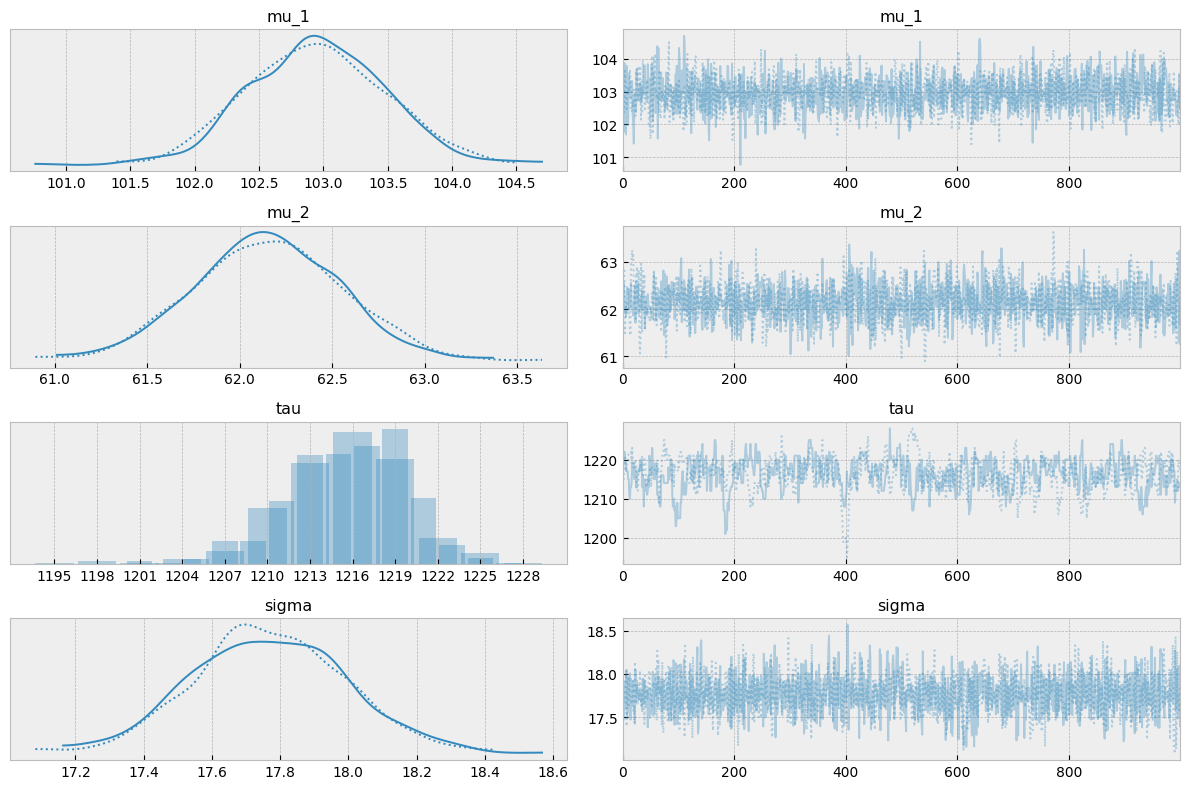

In [5]:
# 1. Summary Statistics
summary = az.summary(trace)
print(summary)

# 2. Visual Diagnostics (Trace Plots)
# Left: Posterior Distributions (Uncertainty)
# Right: Sampling Chains (Convergence - should look like "fuzzy caterpillars")
az.plot_trace(trace)
plt.tight_layout()
plt.show()

--- RESULTS ---
Detected Structural Break Date: 2014-11-05
94% Credible Interval for Change Point: [1208. 1223.]


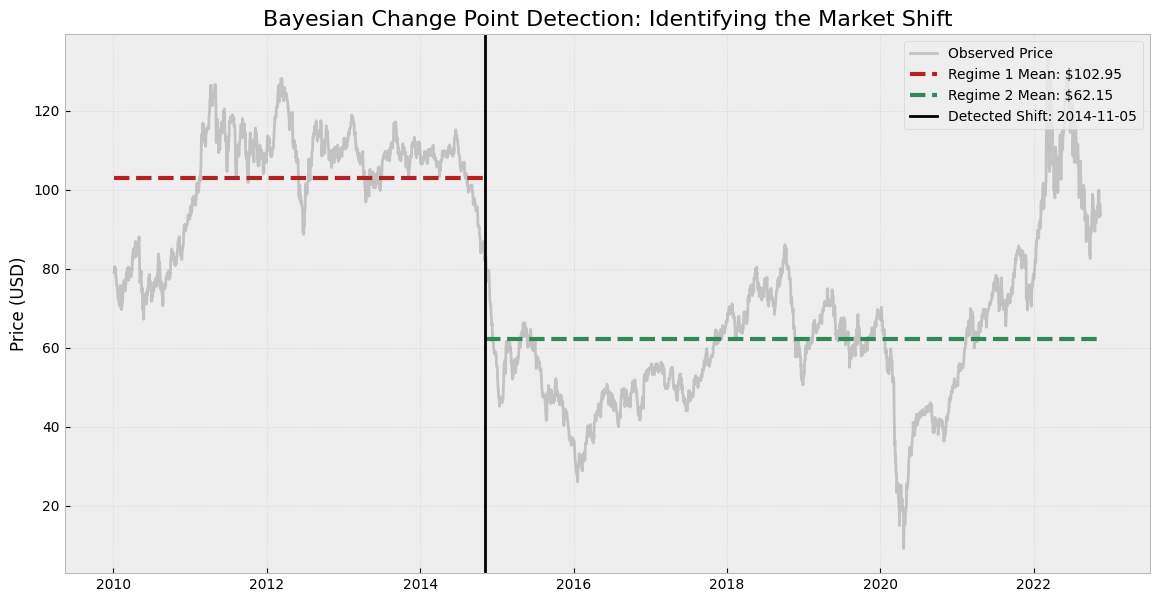

In [6]:
# Extract the estimated change point date
tau_samples = trace.posterior['tau'].values.flatten()
tau_mean_idx = int(tau_samples.mean())
change_date = df.iloc[tau_mean_idx]['Date']

print(f"--- RESULTS ---")
print(f"Detected Structural Break Date: {change_date.date()}")
print(f"94% Credible Interval for Change Point: {az.hdi(trace.posterior['tau']).tau.values}")

# Plotting the result
plt.figure(figsize=(14, 7))

# 1. The Data
plt.plot(df['Date'], df['Price'], color='grey', alpha=0.4, label='Observed Price')

# 2. The Regimes (Means)
mu1_mean = trace.posterior['mu_1'].mean().item()
mu2_mean = trace.posterior['mu_2'].mean().item()

# Draw the mean lines
plt.hlines(mu1_mean, df['Date'].iloc[0], change_date, colors='firebrick', linestyles='--', lw=3, label=f'Regime 1 Mean: ${mu1_mean:.2f}')
plt.hlines(mu2_mean, change_date, df['Date'].iloc[-1], colors='seagreen', linestyles='--', lw=3, label=f'Regime 2 Mean: ${mu2_mean:.2f}')

# 3. The Change Point
plt.axvline(change_date, color='black', linestyle='-', linewidth=2, label=f'Detected Shift: {change_date.date()}')

plt.title('Bayesian Change Point Detection: Identifying the Market Shift', fontsize=16)
plt.ylabel('Price (USD)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Save the results to the outputs folder
import os
output_dir = '../outputs'

# 1. Re-plot and save the Time Series
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='steelblue', linewidth=0.8, alpha=0.9)
plt.title('Brent Oil Prices (2010 - 2022)', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig(f'{output_dir}/01_price_history.png')
plt.close()

# 2. Re-plot and save the Trace (Diagnostics)
az.plot_trace(trace)
plt.tight_layout()
plt.savefig(f'{output_dir}/02_mcmc_trace.png')
plt.close()

# 3. Re-plot and save the Change Point Result
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], color='grey', alpha=0.4, label='Observed Price')
plt.hlines(mu1_mean, df['Date'].iloc[0], change_date, colors='firebrick', linestyles='--', lw=3, label=f'Regime 1: ${mu1_mean:.2f}')
plt.hlines(mu2_mean, change_date, df['Date'].iloc[-1], colors='seagreen', linestyles='--', lw=3, label=f'Regime 2: ${mu2_mean:.2f}')
plt.axvline(change_date, color='black', linestyle='-', linewidth=2, label=f'Shift: {change_date.date()}')
plt.title(f'Detected Market Shift: {change_date.date()}', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig(f'{output_dir}/03_final_changepoint.png')
plt.close()

print("Images saved to outputs/ folder!")

Images saved to outputs/ folder!
